In [15]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk, string

# HW5
### 1 Word clouds

Let first look at some raw wordclouds. We build 2 of them:
- RawText column from the data
- ExtractedSubject and ExtractedBodyText columns concatenated

In [81]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
raw_corpus = '\n'.join(emails.RawText)
extracted_text = emails.ExtractedSubject.fillna('\n') + emails.ExtractedBodyText.fillna('\n')
extracted_emails = pd.DataFrame(extracted_text, columns=['Text'])
extracted_corpus = '\n'.join(extracted_emails.Text)

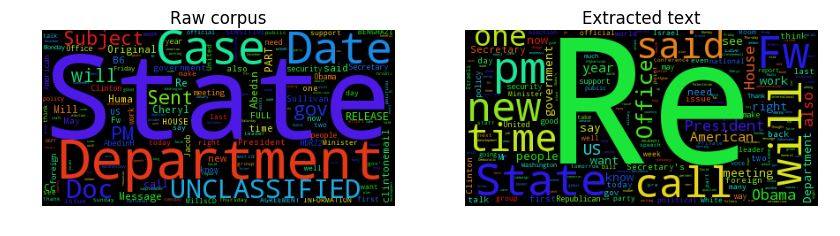

In [3]:
wordcloud = WordCloud().generate(raw_corpus)
wordcloud_extracted = WordCloud().generate(extracted_corpus)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,15))
ax1.imshow(wordcloud)
ax1.set_title('Raw corpus')
ax1.axis('off')
ax2.imshow(wordcloud_extracted)
ax2.set_title('Extracted text')
ax2.axis('off')
plt.show()

As we can see, the RawText contains a lot of annotations (e.g. "UNCLASSIFIED U.S. Department of State Case No.").  
But the extracted text contains more short keywords (e.g. "Fw:", "Re:", etc.)

Now let create a pipeline:
- tokenize sentence and words
- remove stopwords (plus some more related to emails)
- stemming (using the Porter algorithm)

In [75]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Don't forget to run nltk.download() if not already done...

def tokenize(str):
    return [nltk.word_tokenize(s) for s in nltk.sent_tokenize(str)]

stopwords = stopwords.words('english') + ['fvv','fw','fwd','re','am','pm','n\'t','\'s']
def remove_stopwords(words):
    return [w for w in words if w.lower() not in stopwords]

def remove_punctuation(words):
    return [w for w in words if w not in string.punctuation]

porter = nltk.PorterStemmer()
def stemming(words):
    return [porter.stem(word) for word in words]

lemmatizer = WordNetLemmatizer()
def lemmantizing(stemms) :
    return [lemmatizer.lemmatize(stemm) for stemm in stemms]

def run_pipeline(str, 
                 return_as_str=False, 
                 do_remove_stopwords=True, 
                 do_stemming=True,
                 do_lemmantizing=False,
                 do_remove_punctuation=False):
    l = []
    words = []
    sentences = tokenize(str)
    for sentence in sentences:
        if do_remove_stopwords:
            words = remove_stopwords(sentence)
        else:
            words = sentence
        if do_remove_punctuation:
            words = remove_punctuation(words)
        if do_stemming:
            words = stemming(words)
        if do_lemmantizing:
            words = lemmantizing(words)
        if return_as_str:
            l.append(' '.join(words))
        else:
            l.append(words)
    if return_as_str:
        return ' '.join(l)
    else:
        return l

In [5]:
try:
    processed_raw = np.load('processed_raw.npy').item()
    processed_extracted = np.load('processed_extracted.npy').item()
except:
    processed_raw = run_pipeline(raw_corpus, return_as_str=True)
    np.save('processed_raw', processed_raw)
    processed_extracted = run_pipeline(extracted_corpus, return_as_str=True)
    np.save('processed_extracted', processed_extracted)

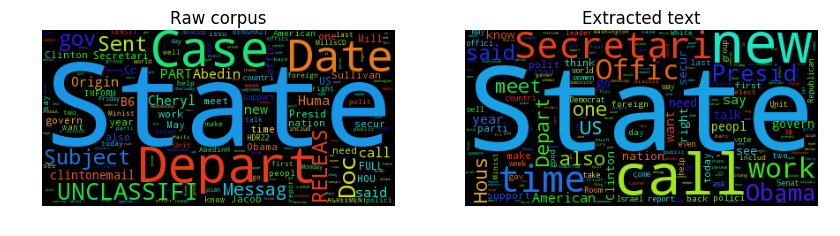

In [6]:
wordcloud = WordCloud().generate(processed_raw)
wordcloud_extracted = WordCloud().generate(processed_extracted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,15))
ax1.imshow(wordcloud)
ax1.set_title('Raw corpus')
ax1.axis('off')
ax2.imshow(wordcloud_extracted)
ax2.set_title('Extracted text')
ax2.axis('off')
plt.show()

The two word clouds are very close together.  
The first approach is faster and straightforward but it could lack some fine grained tuning regarding language processing.  
The second one is way slower as we run through many pre-processing steps. But its main advantage is the ability to tune some parameters (stopwords, stemming, etc.).

### Part 2

Finding countries in the whole corpus:

__Note:__ We only retrieve countries by their name.  
_When trying with abbreviations we get a lot of false results._

In [7]:
from pycountry import countries

def get_country(str):
    try:
        c = countries.get(name=str.title()).name
    except:
        c = None
    return c

def retrieve_countries(emails):
    mentioned = {}
    
    def add(country, i):
        if country in mentioned:
            mentioned[country].append(i)
        else:
            mentioned[country] = [i]
    
    for i, email in emails.iteritems():
        tokens = nltk.word_tokenize(email)
        for token in tokens:
            country = get_country(token)
            if country:
                add(country, i)
    return mentioned

try:
    mentioned = np.load('mentioned.npy').item()
    mentioned2 = np.load('mentioned2.npy').item()
except:
    mentioned = retrieve_countries(emails.RawText)
    np.save('mentioned2.npy', mentioned)
    mentioned2 = retrieve_countries(extracted_emails.Text)
    np.save('mentioned2.npy', mentioned2)

Now we compute the polarities using NLTK vader package:

In [8]:
try:
    polarities = np.load('polarities.npy')
    polarities2 = np.load('polarities2.npy')
except:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()
    polarities = [sid.polarity_scores(email) for email in emails.RawText]
    np.save('polarities.npy', polarities)
    polarities2 = [sid.polarity_scores(email) for email in extracted_emails.Text]
    np.save('polarities2.npy', polarities2)

In [17]:
result = []
for country, emails in mentioned2.items():
    for email in set(emails):
        polarity = polarities2[email]['compound']
        result.append([country, polarity])
result = pd.DataFrame(result, columns=['Country','Polarity'])
sorted = result.groupby('Country').mean().sort_values(by='Polarity')
colors = ['b' if pol > 0 else 'r' for pol in sorted.Polarity]

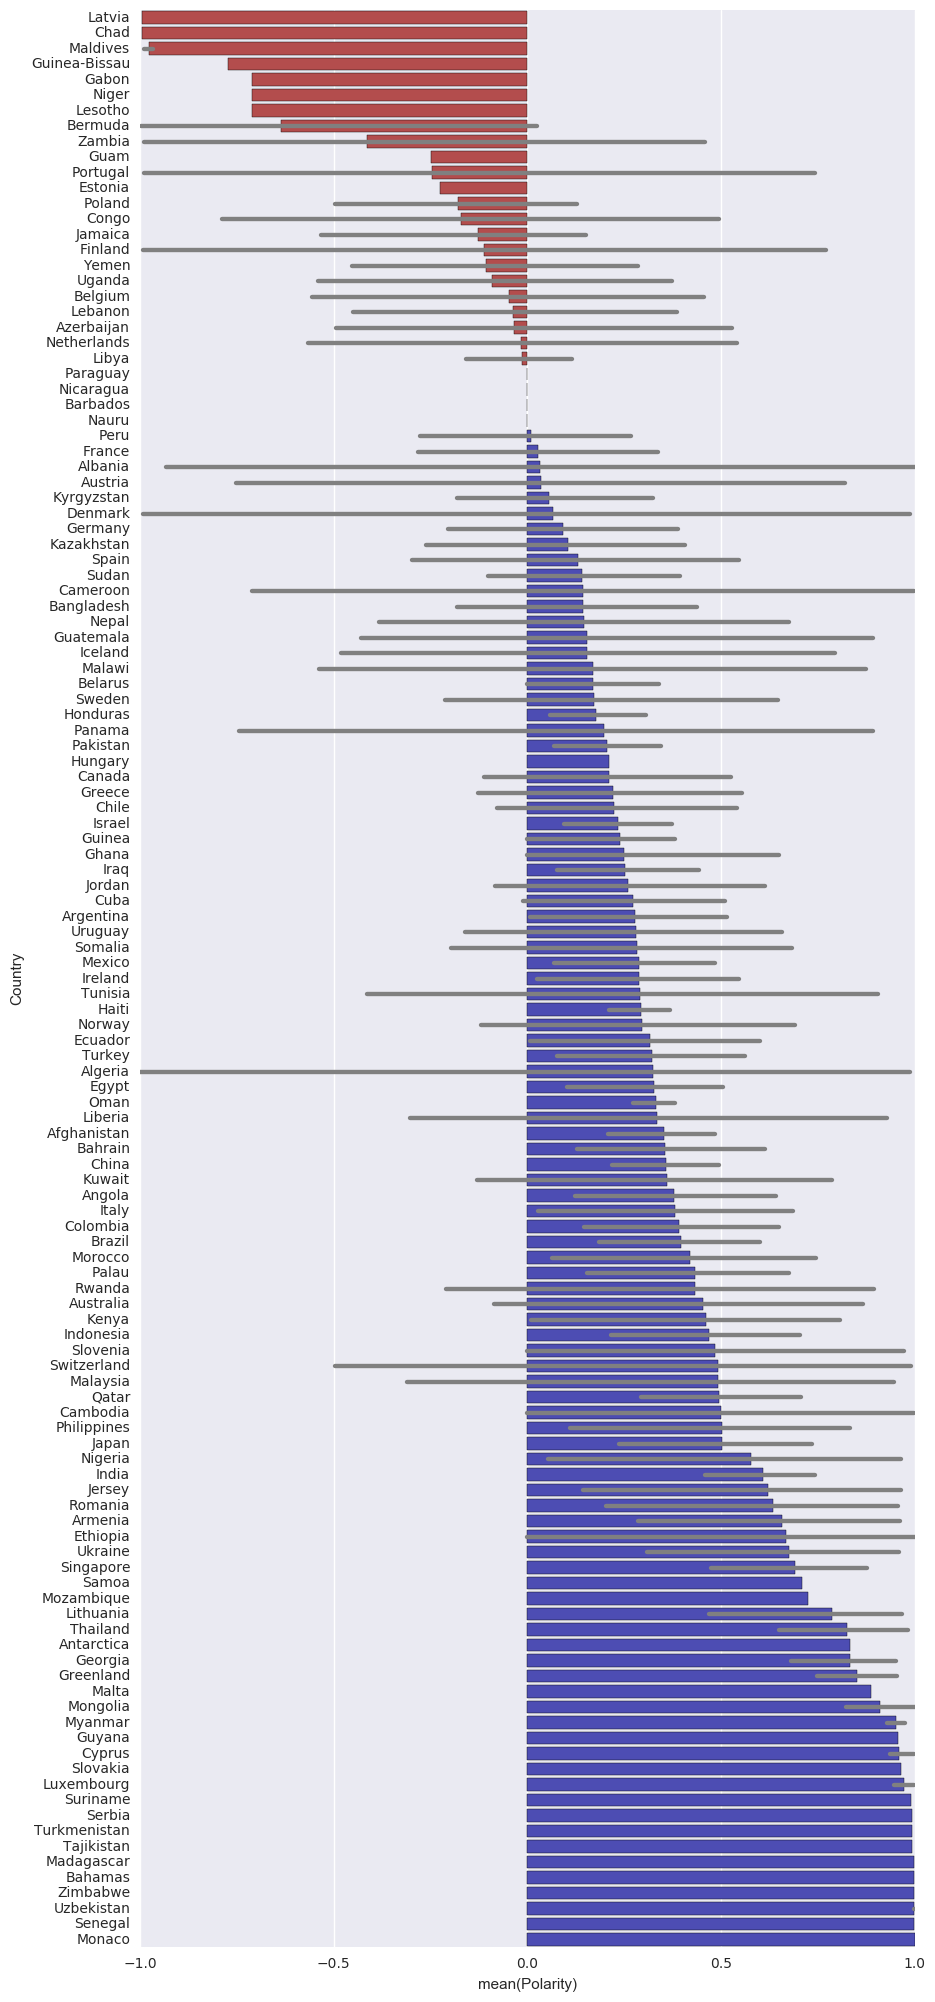

In [24]:
plt.subplots(figsize=(10,25))
sns.barplot(x='Polarity', 
            y='Country', 
            data=result, 
            order=sorted.index, 
            palette=colors, 
            saturation=.4, 
            errcolor='gray')
plt.show()

In [ ]:
def demo_liu_hu_lexicon(sentence):
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
        elif word in opinion_lexicon.negative():
            neg_words += 1

    if pos_words > neg_words:
        print('Positive')
    elif pos_words < neg_words:
        print('Negative')
    elif pos_words == neg_words:
        print('Neutral')


str = "This movie was actually neither that funny, nor super witty."

demo_liu_hu_lexicon(str)
#demo_vader_instance(str)
#sid = SentimentIntensityAnalyzer()
#sid.polarity_scores(str)#['compound']
#sentiments = [map(sid.polarity_scores, t) for t in emails['RawText']]

### Part 3

Exploring the topics:

In [76]:
tokens = run_pipeline(extracted_corpus, do_remove_punctuation=True, do_lemmantizing=True, do_stemming=False)

In [77]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(s) for s in tokens]

In [78]:
N_TOPICS = 20
lda = LdaModel(corpus, num_topics=N_TOPICS, id2word=dictionary)

In [79]:
lda.print_topics(num_topics=N_TOPICS, num_words=20)

[(0,
  '0.033*"2" + 0.015*"health" + 0.014*"voter" + 0.009*"add" + 0.009*"Thanks" + 0.009*"senior" + 0.009*"20" + 0.008*"rather" + 0.008*"claim" + 0.008*"office"'),
 (1,
  '0.021*"issue" + 0.018*"like" + 0.014*"asked" + 0.014*"settlement" + 0.012*"view" + 0.008*"economic" + 0.008*"always" + 0.008*"case" + 0.008*"\'d" + 0.008*"seems"'),
 (2,
  '0.018*"election" + 0.017*"going" + 0.013*"nuclear" + 0.012*"Congress" + 0.012*"Obama" + 0.010*"medium" + 0.010*"plan" + 0.010*"Netanyahu" + 0.009*"politics" + 0.009*"would"'),
 (3,
  '0.043*"Secretary" + 0.028*"Office" + 0.022*"House" + 0.021*"State" + 0.018*"Room" + 0.015*"Department" + 0.015*"MEETING" + 0.013*"White" + 0.012*"route" + 0.011*"ARRIVE"'),
 (4,
  '0.015*"New" + 0.014*"work" + 0.014*"back" + 0.013*"Party" + 0.011*"--" + 0.009*"York" + 0.009*"Tea" + 0.009*"make" + 0.008*"could" + 0.007*"process"'),
 (5,
  '0.019*"•" + 0.014*"AP" + 0.013*"book" + 0.010*"family" + 0.010*"Beck" + 0.009*"course" + 0.009*"mean" + 0.009*"strategy" + 0.008*

### Part 4 BONUS:

In [94]:
import networkx as nx

#persons = pd.read_csv('hillary-clinton-emails/Persons.csv', header=0, index_col=0)
#aliases = pd.read_csv('hillary-clinton-emails/Aliases.csv', header=0, index_col=0)
receivers = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv', header=0, index_col=0)

In [182]:
senders = emails[['Id','SenderPersonId']]
senders = senders[pd.notnull(senders.SenderPersonId)]
print('%.2f' % (100*len(senders)/len(emails)), '% of emails have a valid sender.')

98.02 % of emails have a valid sender.


In [267]:
G = nx.Graph()
for _, emailId, i in senders.itertuples():
    for _, emailId2, j in receivers[receivers.EmailId == emailId].itertuples():
        assert emailId == emailId2
        G.add_edge(i, j, email=emailId)

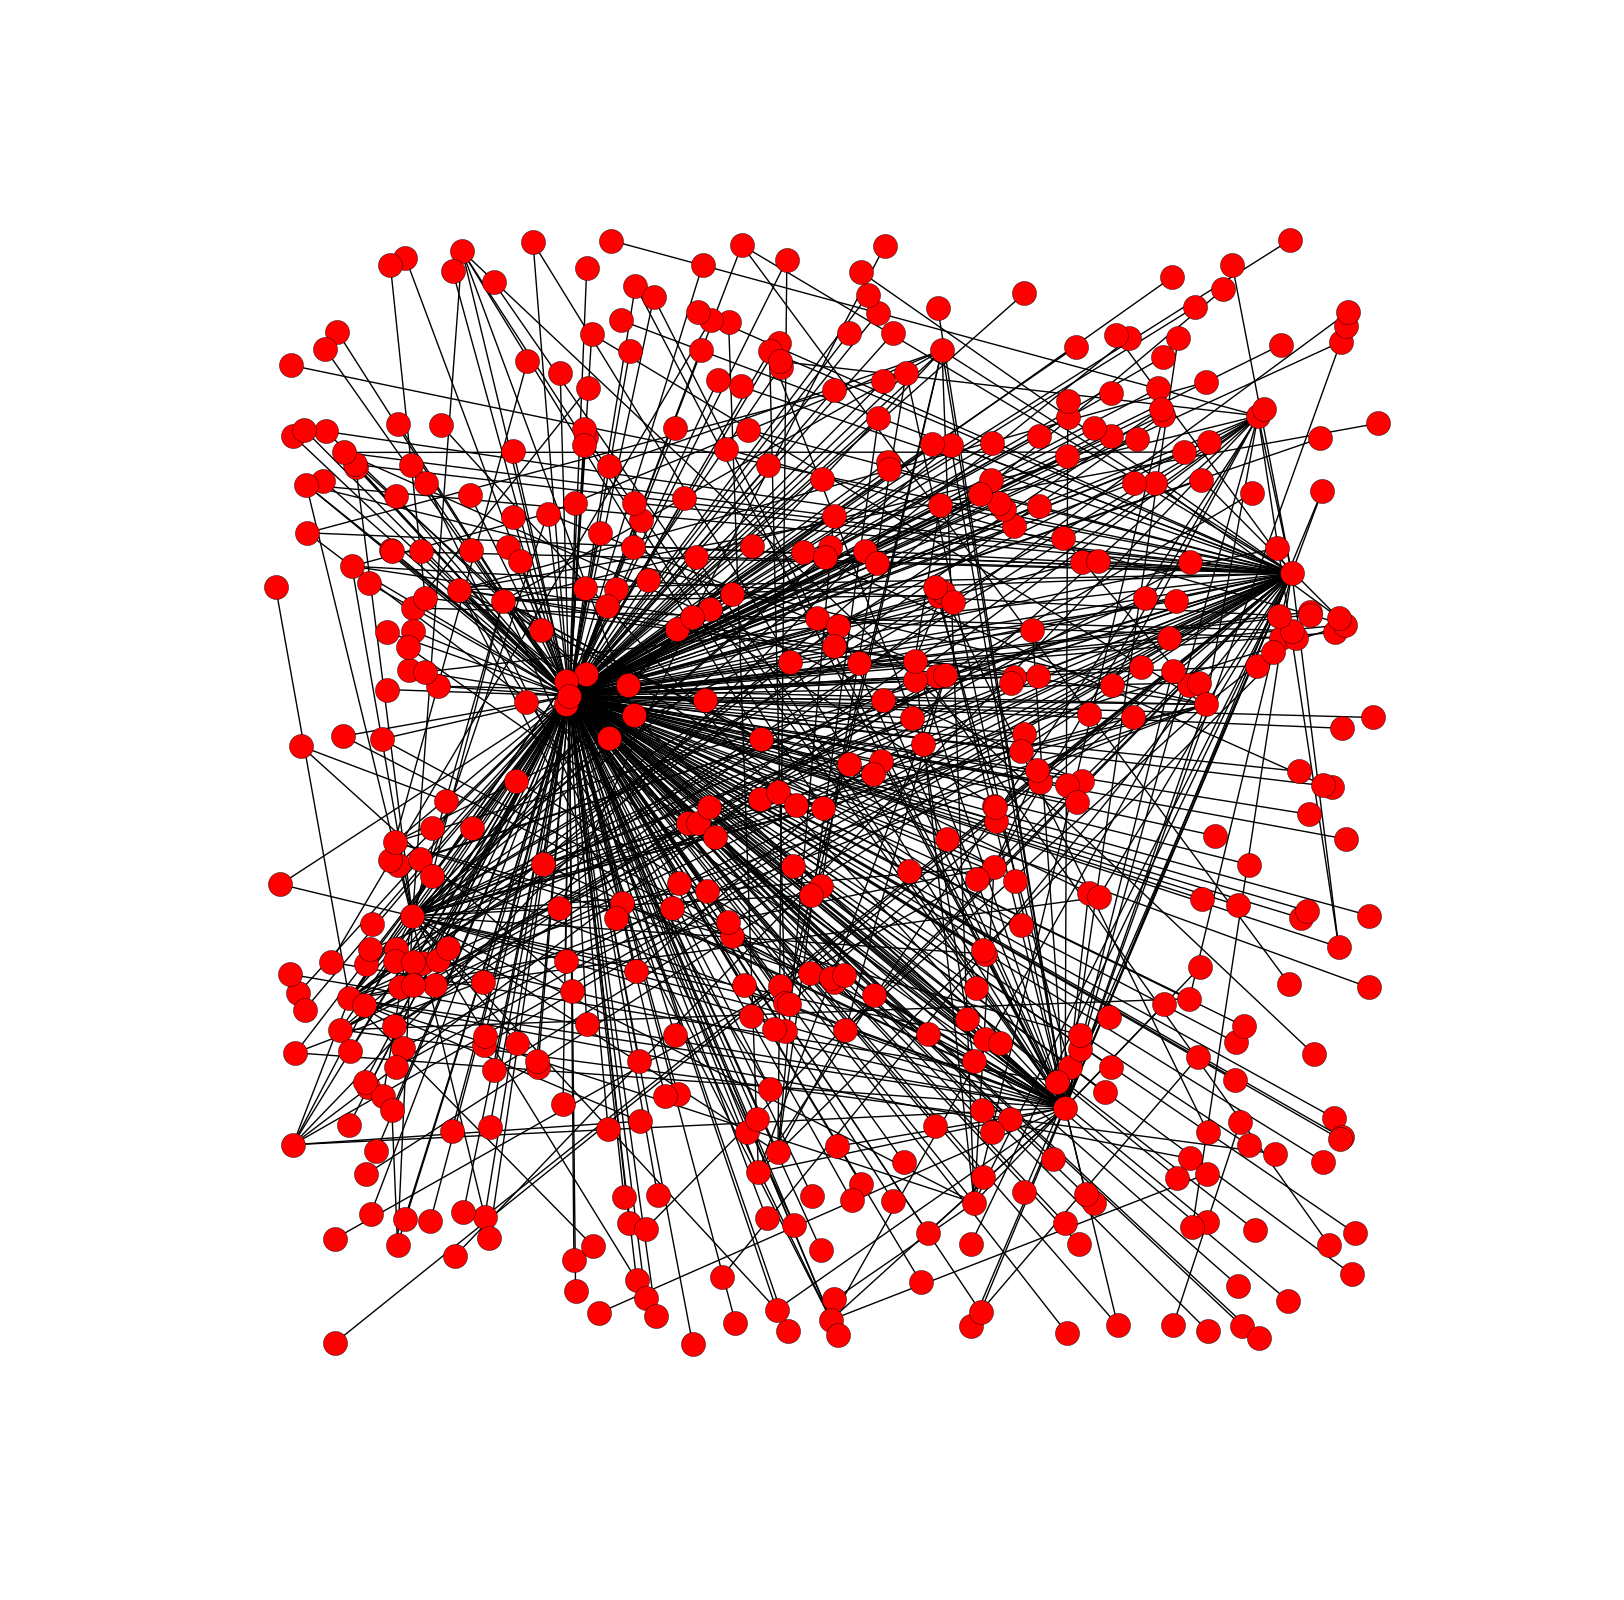

In [256]:
plt.subplots(figsize=(20,20))
nx.draw_random(G)

In [279]:
#graphs = list(nx.connected_component_subgraphs(G))
#community_emails = []
#for graph in graphs:
#    l = []
#    for _,_,data in graph.edges_iter(data=True):
#        email = emails[emails.Id == data['email']]
#        l.append(email.ExtractedSubject.fillna(' ') + email.ExtractedBodyText.fillna(' '))
#    community_emails.append(l)

In [281]:
import community

In [284]:
community.best_partition(G) ## ???????

AttributeError: module 'community' has no attribute 'best_partition'